# Business Analytics

## Project description

You've done beautifully in the Practicum course, and you've been offered an internship in the analytical department at Yandex.Afisha. Your first task is to help optimize marketing expenses.

You have:
* Server logs with data on Yandex.Afisha visits from June 2017 through May 2018
* Dump file with all orders for the period
* Marketing expenses statistics

You are going to study:
* How people use the product
* When they start to buy
* How much money each customer brings
* When they pay off


### Content
        
* **[Download the Data and Prepare it for Analysis](#1)**
    * [The Visits Table](#1.1)
    * [The Orders Table](#1.2)
    * [The Costs Table](#1.3)
<br>
<br>
* **[Reports and Metrics](#2)**
<br>

    * **[Product](#2.1)**
        * [Daily Visits & Users](#2.1.1)
        * [Days of the Week](#2.1.2)
        * [Weekly Users & Visits](#2.1.3)
        * [Monthly Users & Visits](#2.1.4)
        * [Sticky WAU and MAU](#2.1.5)
        * [Session Lenght](#2.1.6)
        * [User Retention](#2.1.7)
<br>
<br>
    * **[Sales](#2.2)**
        * [When do People start buying?](#2.2.1)
        * [Number of Orders](#2.2.2)
        * [Average Purchase Size](#2.2.3)
        * [Lifetime Value by Source](#2.2.4)
        * [Lifetime Value by Cohort](#2.2.5)
<br>
<br>
    * **[Marketing](#2.3)**
        * [Total Costs](#2.3.1)
        * [Customer Acquisition Cost (CAC)](#2.3.2)
        * [How worthwile where the investments (ROMI)](#2.3.3)
            * [ROMI by Cohort](#2.3.3.1)
            * [ROMI by Source](#2.3.3.2)
            * [Profit by Source](#2.3.3.3)      
<br>
<br>
* **[Overall Conclusion](#3)**

<a id="1"></a>
## Download the Data and prepare it for Analysis

We will load all three datasets and prepare them by adding calculated columns etc.

* [The Visits Table](#1.1)
* [The Orders Table](#1.2)
* [The Costs Table](#1.3)

Before we start our analysis we need to download the datasets and add some additional calculated columns. We will also set up our notebook with the libraries and colors we will use for visualization.

In [1]:
# importing the libraries
import pandas as pd
import numpy as np
import matplotlib as matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# defining a color scheme for visualizations
neutral = '#CED2CC' # light grey
header = '#23282D' # anthrazit
data1 = '#6AB187' # pastel green
data2 = '#1F3F49' # forest green  
data3 = '#4CB5F5' # light blue
accent1 = '#D32D41' #pinkish red
accent2 = '#B3C100' # yellow

# defining a colormap for most of the heatmaps
norm = matplotlib.colors.Normalize(-1,1)
colors = [[norm(-1.0), data2],
          [norm(-0.6), data3],
          [norm( 0.4), accent2],
          [norm( 1.0), accent1]]

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

<a id="1.1"></a>
### The Visits Table

In [2]:
# importing the dataset
visits = pd.read_csv("D:\laura\Documents\Practicum100\Datasets\log_visits.csv",
                     dtype={'Device': 'category'},
                     parse_dates=['Start Ts', 'End Ts'])

In [3]:
# taking a look at a few rows of our table
visits.head()

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [4]:
# renaming columns to more convienient names
visits.rename(columns={'Device':'device',
                       'End Ts':'end_ts',
                       'Source Id':'source_id',
                       'Start Ts':'start_ts',
                       'Uid':'uid'}, inplace=True)

# checking for duplicates
print('Duplicated Entries:',visits.duplicated().sum())

Duplicated Entries: 0


In [5]:
# adding columns for date, week, month, year and duration and adding the best fitting dtype
visits['date'] = pd.to_datetime(visits['start_ts'].dt.date)
visits['week'] = visits['start_ts'].dt.year.astype(str) + '-' + visits['start_ts'].dt.week.astype(str)
visits['month'] = visits['start_ts'].astype('datetime64[M]')
visits['duration'] = (visits['end_ts'] - visits['start_ts']).dt.seconds

In [6]:
visits.head()

,device,end_ts,source_id,start_ts,uid,date,week,month,duration
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017-51,2017-12-01,1080
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018-8,2018-02-01,1680
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-26,2017-07-01,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,2018-20,2018-05-01,1440
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,2017-52,2017-12-01,0


In [7]:
# adding the date of the first visit, first visit month and cohort lifetime(by month)
first_visit = visits.groupby(['uid'])['date'].min()
first_visit.name = 'first_visit'
visits = visits.merge(first_visit, on='uid', how='left')
visits['first_visit'] = visits['first_visit'].astype('datetime64[M]')

# adding the cohort size to the visits table
cohort_size = visits.groupby('first_visit').agg({'uid':'nunique'}).reset_index()
cohort_size = cohort_size.rename(columns={'uid':'cohort_size'})
visits = visits.merge(cohort_size, on = 'first_visit', how='left')

# calculating the cohort_lifetime in each month
visits['cohort_lifetime'] = ((visits['month'] - visits['first_visit'].astype('datetime64[M]'))
                             / np.timedelta64(1, 'M')).round().astype(int)

# checking for number of entries, null values, memory usage and datatypes
visits.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 359400 entries, 0 to 359399
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   device           359400 non-null  category      
 1   end_ts           359400 non-null  datetime64[ns]
 2   source_id        359400 non-null  int64         
 3   start_ts         359400 non-null  datetime64[ns]
 4   uid              359400 non-null  uint64        
 5   date             359400 non-null  datetime64[ns]
 6   week             359400 non-null  object        
 7   month            359400 non-null  datetime64[ns]
 8   duration         359400 non-null  int64         
 9   first_visit      359400 non-null  datetime64[ns]
 10  cohort_size      359400 non-null  int64         
 11  cohort_lifetime  359400 non-null  int32         
dtypes: category(1), datetime64[ns](5), int32(1), int64(3), object(1), uint64(1)
memory usage: 51.0 MB


In [8]:
# looking at the numerical columns and their values
visits.describe()

,source_id,uid,duration,cohort_size,cohort_lifetime
count,359400.000000,3.594000e+05,359400.000000,359400.000000,359400.000000
mean,3.750515,9.202557e+18,643.506489,20082.706909,0.969377
std,1.917116,5.298433e+18,1016.334786,5557.186817,2.140980
min,1.000000,1.186350e+13,0.000000,10181.000000,0.000000
25%,3.000000,4.613407e+18,120.000000,15273.000000,0.000000
50%,4.000000,9.227413e+18,300.000000,22197.000000,0.000000
75%,5.000000,1.372824e+19,840.000000,25268.000000,1.000000
max,10.000000,1.844668e+19,84480.000000,27248.000000,11.000000


In [9]:
print('Visits without duration:', len(visits[visits['duration'] == 0]))
print('Share of visits without duration: {:.0%}'.format(len(visits[visits['duration'] == 0])/len(visits)))

Visits without duration: 35794
Share of visits without duration: 10%


**Conclusion**

We succesfully imported the data on individual visits to our website. While importing we already parsed the columns that hold timestamps as dates and defined the `source_id` and `device` as categories since they only hold a limited amount of possible values.

To prepare the table for the next steps we replaced the column names with lowercase names that have no spaces between words. We then added new columns for `date`, `week`, `month`, `year` and `duration` and changed them to a fitting datatype that will also keep the memory usage low.

Our table now holds **359.400** entries in **10** columns. Since there are no empty values we don't need to fill or drop anything.

The values in the calculated columns for week, month and year also look correct. The range of values in them fit their description and there don't seem to be any errors.

There is at least one entry where the duration is **0 seconds**, meaning that the timestamps for the start and end of the session are the same. This is true for around *10%** of entries. Maybe the customers opend the website but closed it before it loaded completely. But there are no negative values so for now we can assume that the values are correct and logical. The longest visit was almost **24 hours** long, the user probably forgot to close the site/log out. Most visits seem to range between **2 - 14** minutes.

[back to content](#top) - [back to Loading the Data](#1)

<a id="1.2"></a>
### The Orders Table

In [10]:
# importing the dataset
orders = pd.read_csv("D:\laura\Documents\Practicum100\Datasets\orders_log_us.csv",
                     parse_dates=['Buy Ts'])

# taking a look at a few rows of our table
orders.head(10)

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450
5,2017-06-01 08:43:00,0.18,10402394430196413321
6,2017-06-01 08:54:00,1.83,12464626743129688638
7,2017-06-01 09:22:00,1.22,3644482766749211722
8,2017-06-01 09:22:00,3.30,17542070709969841479
9,2017-06-01 09:23:00,0.37,1074355127080856382


In [11]:
# renaming the existing columns
orders.rename(columns={'Buy Ts':'buy_ts', 'Revenue':'revenue', 'Uid':'uid'}, inplace=True)

# checking for duplicates
print('Duplicated Entries:',orders.duplicated().sum())

Duplicated Entries: 0


In [12]:
# adding new columns for date, week, month and year and choosing a fitting datatype
orders['date'] = pd.to_datetime(orders['buy_ts'].dt.date)
orders['week'] = orders['buy_ts'].dt.week
orders['month'] = orders['buy_ts'].astype('datetime64[M]')

# adding first_visit, cohort_size and cohort_lifetime to the orders table
orders = orders.merge(first_visit, on='uid', how='left')
orders['cohort_lifetime'] = ((orders['date'] - orders['first_visit'])
                             / np.timedelta64(1, 'M')).round().astype(int)
orders = orders.merge(cohort_size, on='first_visit', how='left')

# checking the number of entries, null values, datetypes and memory usage
orders.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50415 entries, 0 to 50414
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   buy_ts           50415 non-null  datetime64[ns]
 1   revenue          50415 non-null  float64       
 2   uid              50415 non-null  uint64        
 3   date             50415 non-null  datetime64[ns]
 4   week             50415 non-null  int64         
 5   month            50415 non-null  datetime64[ns]
 6   first_visit      50415 non-null  datetime64[ns]
 7   cohort_lifetime  50415 non-null  int32         
 8   cohort_size      2425 non-null   float64       
dtypes: datetime64[ns](4), float64(2), int32(1), int64(1), uint64(1)
memory usage: 3.7 MB


In [13]:
# taking a look at numerical columns and their values
orders.describe()

,revenue,uid,week,cohort_lifetime,cohort_size
count,50415.000000,5.041500e+04,50415.000000,50415.000000,2425.000000
mean,4.999647,9.098161e+18,27.152970,1.201746,17789.226392
std,21.818359,5.285742e+18,16.692396,2.337541,5521.980272
min,0.000000,3.135781e+14,1.000000,0.000000,10181.000000
25%,1.220000,4.533567e+18,11.000000,0.000000,13259.000000
50%,2.500000,9.102274e+18,26.000000,0.000000,13259.000000
75%,4.890000,1.368290e+19,43.000000,1.000000,22624.000000
max,2633.280000,1.844617e+19,52.000000,12.000000,27248.000000


In [14]:
print('Orders with 0 revenue:', len(orders[orders['revenue'] == 0]))
print('Share of orders without revenue: {:.2%}'.format(len(orders[orders['revenue'] == 0])/len(visits)))

Orders with 0 revenue: 51
Share of orders without revenue: 0.01%


**Conclusion**

We imported the `costs` table and already parsed the `Buy TS` column as date. We renamed the existing columns to all lowercase strings without spaces and added additional columns for the `week`, `month` and `year` an order was placed.

Our dataset has **50.415** entries in 7 columns and no missing values. When we take a look at the *.describe()* method we can see that the values for our calculated columns seem logical and correct.

Some orders have a revenue of **0**. Maybe the customers had a gift certificate or voucher that they used for their order. This is only true for **51** orders which is only *0.01%*.

[back to content](#top) - [back to Loading the Data](#1)

<a id="1.3"></a>
### The Costs Table

In [15]:
# importing the dataset
costs = pd.read_csv("D:\laura\Documents\Practicum100\Datasets\costs_us.csv",
                    parse_dates=['dt'])

# taking a look at our table
costs.head(10)

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08
5,1,2017-06-06,40.39
6,1,2017-06-07,40.59
7,1,2017-06-08,56.63
8,1,2017-06-09,40.16
9,1,2017-06-10,43.24


In [16]:
# renaming the existing columns
costs.rename(columns={'dt':'date'}, inplace=True)

# checking for duplicates
print('Duplicated Entries:', costs.duplicated().sum())

Duplicated Entries: 0


In [17]:
# adding columns for week, month
costs['week'] = costs['date'].dt.week.astype('int8')
costs['month'] = costs['date'].astype('datetime64[M]')

# checking the number of entries, null values, memory usage and datatypes
costs.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   source_id  2542 non-null   int64         
 1   date       2542 non-null   datetime64[ns]
 2   costs      2542 non-null   float64       
 3   week       2542 non-null   int8          
 4   month      2542 non-null   datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(1), int8(1)
memory usage: 82.0 KB


In [18]:
# taking a closer look at the numerical columns
costs.describe()

,source_id,costs,week
count,2542.000000,2542.000000,2542.000000
mean,4.857199,129.477427,26.556648
std,3.181581,156.296628,14.999690
min,1.000000,0.540000,1.000000
25%,2.000000,21.945000,14.000000
50%,4.000000,77.295000,27.000000
75%,9.000000,170.065000,40.000000
max,10.000000,1788.280000,52.000000


**Conclusion**

We loaded our dataset `costs` and parsed the `dt` column as date. We renamed the column to `date` and also added additional columns with the `week`, `month` and `year`.

Our table has **2542** entries in 6 columns and no missing values. The values for our new columns look correct and the `costs` also don't have any noticeable errors from what we can see.

[back to content](#top) - [back to Loading the Data](#1)

<a id="2"></a>
## Reports and Metrics

* [Product](#2.1)
* [Sales](#2.2)
* [Marketing](#2.3)

<a id="2.1"></a>
### Product

We want to find out how many people use our product (website) every day, week, and month. We will also find out how many sessions there are in these timeframes (One user might have more than one session.), how long sessions usually are and how often users come back.

* [Daily Users & Visits](#2.1.1)
* [Distribution on Days of the Week](#2.1.2)
* [Weekly Users & Visits](#2.1.3)
* [Monthly Users & Visits](#2.1.4)
* [Session Lenght](#2.1.5)
* [Visits per User](#2.1.6)
* [User Retention](#2.1.7)

First of all let's define a function that let's us display our reports on the daily, weekly and monthly visits:

In [19]:
def visits_plots(df, timeframe, x_column, xtick_size):
    # setting up the figure and title
    plt.figure(figsize=(20,6))
    plt.suptitle('{} Users & Visits'.format(timeframe), fontsize=24, color=header)
    
    # setting up a histogram on the number of total visits
    plt.subplot(1,2,1)
    plt.title('Distribution', fontsize=18, color=header)
    plt.tick_params(labelsize=12, color=header)
    plt.xlabel('Unique {} Users'.format(timeframe), color=accent1, fontsize=14)
    plt.ylabel('Count', color=accent1, fontsize=14)
    sns.histplot(df['unique_users'], bins=25, color=data1)

    # setting up a linechart with total visits and unique users
    plt.subplot(1,2,2)
    plt.title('Visits & Users', color=header, fontsize=18)
    plt.xticks(fontsize=xtick_size, color=header, rotation=90)
    plt.yticks(fontsize=12, color=header)
    plt.xlabel(x_column, color=accent1, fontsize=14)
    plt.ylabel('Count', color=accent1, fontsize=14)
    plt.grid(axis='y', color=neutral)
    plt.plot(df[x_column], df['total_visits'], color=data2, label='total_visits')
    plt.plot(df[x_column], df['unique_users'], color=data3, label='unique_users')
    plt.legend(fontsize=12)
    
    
    # displaying the plots
    plt.show()

<a id="2.1.1"></a>
#### Daily Visits & Users

In [20]:
# calculating the number of visits and number of unique users for each day
daily_visits = visits.groupby('date').agg({'uid':['count', 'nunique']}).reset_index()

# renaming the columns
daily_visits.columns = ['date', 'total_visits', 'unique_users']

# taking a look at the data
display(daily_visits.head(15))

# looking at the top5 and flop5 days in numbers of visits:
print()
print('Top 5')
display(daily_visits.nlargest(5, 'unique_users'))
print()
print('Bottom 5')
display(daily_visits.nsmallest(5, 'unique_users'))

# displaying information about the values in both columns
display(daily_visits.describe())

# calculating the DAU, separated for devices
DAU = daily_visits['unique_users'].mean()

DAU_touch = (visits[visits['device'] == 'touch']
             .groupby('date')
             .agg({'uid':'nunique'})
             .reset_index()
             .uid
             .mean())

DAU_desktop = (visits[visits['device'] == 'desktop']
               .groupby('date')
               .agg({'uid':'nunique'})
               .reset_index()
               .uid
               .mean())

# printing the metrics
print('DAU:', round(DAU))
print('DAU Touch:', round(DAU_touch))
print('DAU Desktop:', round(DAU_desktop))

,date,total_visits,unique_users
0,2017-06-01,664,605
1,2017-06-02,658,608
2,2017-06-03,477,445
3,2017-06-04,510,476
4,2017-06-05,893,820
5,2017-06-06,875,797
6,2017-06-07,788,699
7,2017-06-08,939,868
8,2017-06-09,755,695
9,2017-06-10,375,350



Top 5


,date,total_visits,unique_users
176,2017-11-24,4042,3319
363,2018-05-31,2256,1997
177,2017-11-25,2089,1817
245,2018-02-01,1878,1640
298,2018-03-26,1796,1609



Bottom 5


,date,total_visits,unique_users
303,2018-03-31,1,1
302,2018-03-30,134,131
72,2017-08-12,296,271
65,2017-08-05,304,280
73,2017-08-13,293,281


,total_visits,unique_users
count,364.000000,364.000000
mean,987.362637,907.991758
std,418.994796,370.513838
min,1.000000,1.000000
25%,635.500000,594.000000
50%,1003.000000,921.000000
75%,1280.000000,1173.000000
max,4042.000000,3319.000000


DAU: 908
DAU Touch: 253
DAU Desktop: 659


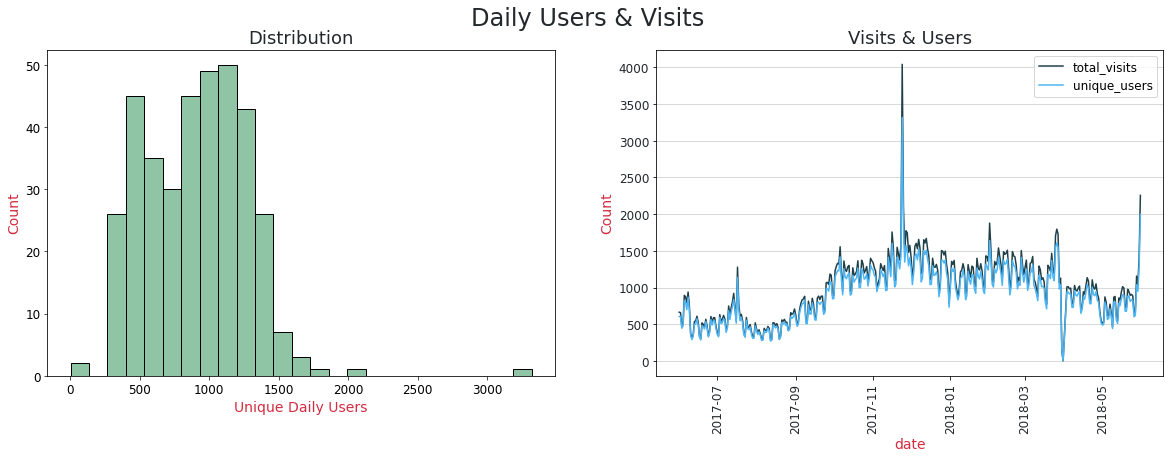

In [21]:
visits_plots(daily_visits, 'Daily', 'date', 12)

**Conclusion**

We made a report on how many visits and unique users are there for our service on each day (`daily_visits`). Since the number of days is way to large to display the whole report we first take a look at the values with the help of *.describe()*.

We can see some days only had **1** visit from **1** user but others had up to **4042** visits from **3319** unqiue users. Maybe there was a special promotion on those days or a very popular event was anounced. Most days had between **600** and **1200** visits from unique users. Only some of them seem to return to the site more than once on that day.

We usually have around **990** visits from **908** (*DAU*) users per day. Most users use their desktop devices to acces the website (*DAU = 659*) while on average *253* users use their mobile/touch devices.

A look at the histogram confirms those observations. But the line graph shows something interesting. After a good start in June 2017 we had a small decline but from August the numbers picked up. We reached a peak in December and managed to hold up the average number of visits for a few months. Perhaps people visited the website more often for Christmas events or gift vouchers. But after a trough in April 2018 (maybe the website was down?) the number of visits didn't pick up again. Only recently there was a peak again and we saw the second most users of all time on May 31, 2018 (2000 people visited our site).

[back to content](#top) | [back to Reports and Metrics](#2)

<a id="2.1.2"></a>
#### Days of the Week

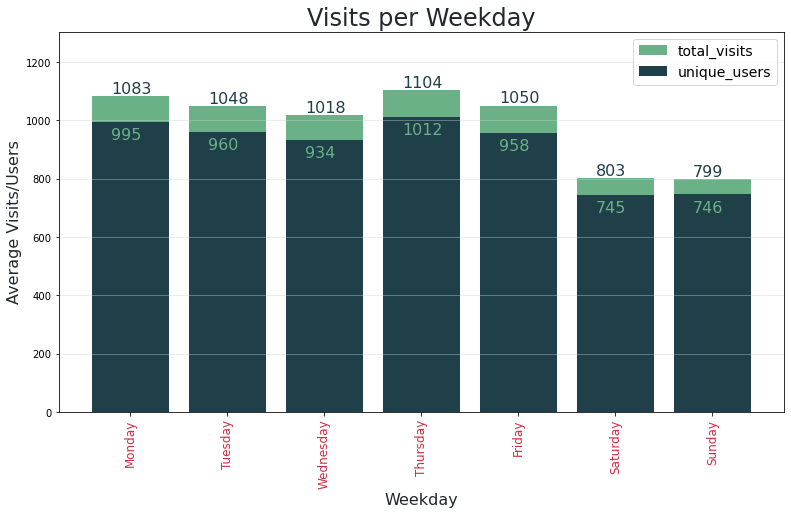

In [22]:
# finding the day of the week for each visit
daily_visits['day'] = daily_visits['date'].dt.weekday
daily_visits['day_of_week'] = daily_visits['date'].dt.day_name()
weekday_visits = daily_visits.groupby(['day', 'day_of_week']).agg('mean').reset_index()

# defining the columns that we want to use in our graph
x=weekday_visits['day_of_week']
y=weekday_visits['total_visits']
y2=weekday_visits['unique_users']

# setting up the plot and some parameters
plt.figure(figsize = (13,7))
plt.title('Visits per Weekday', fontsize = 24, color=header)
plt.grid(color=neutral, axis='y', alpha=0.5)
plt.ylim(0,y.max()+200)

# the actual plot
bars = plt.bar(x, height=y, color=data1)
bars2 = plt.bar(x, height=y2, color=data2)

xlocs, xlabs = plt.xticks()

# reference x so you don't need to change the range each time x changes
xlocs=[i for i in x]
xlabs=[i for i in x]

# adding some more information to the plot
plt.xlabel('Weekday', fontsize = 16, color = header)
plt.ylabel('Average Visits/Users', fontsize = 16, color = header)
plt.xticks(xlocs, xlabs, fontsize=12, rotation = 90, color=accent1)
plt.legend(['total_visits', 'unique_users'], fontsize = 14)

# adding the amount of trips to each bar
for bar in bars:
    yval = round(bar.get_height())
    plt.text(bar.get_x()+0.2, yval+10, yval, fontsize=16, color = data2)
    
for bar in bars2:
    yval = round(bar.get_height())
    plt.text(bar.get_x()+0.2, yval-60, yval, fontsize=16, color = data1)

# displaying the graph
plt.show()

**Conclusion**

The most busy day of the week usually is on Thursday. Our website on average sees more than **1100** visits from over **1000** individual users. On weekends we usually only get around **800** visits from **750** users.

The number of visits and users for the other days is very similar with just above **1000** visits from **960** users.

[back to content](#top) | [back to Reports and Metrics](#2)

<a id ="2.1.3"></a>
#### Weekly Users & Visits

In [23]:
# calculating the number of visits and number of unique users for each week
weekly_visits = (visits
                 .groupby('week')
                 .agg({'uid':['count','nunique']})
                 .reset_index()
                 .sort_values('week'))

# renaming the columns
weekly_visits.columns = ['week', 'total_visits', 'unique_users']

# taking a look at the data
display(weekly_visits.head(10))

# looking at the top5 and flop5 days in numbers of visits:
print()
print('Top5')
display(weekly_visits.nlargest(5, 'unique_users'))
print()
print('Bottom 5')
display(weekly_visits.nsmallest(5, 'unique_users'))

# displaying information about the values in both columns
display(weekly_visits.describe())

# calculating the DAU, separated for devices
WAU = weekly_visits['unique_users'].mean()
WAU_touch = (visits[visits['device'] == 'touch']
             .groupby('week')
             .agg({'uid':'nunique'})
             .reset_index()
             .uid
             .mean())

WAU_desktop = (visits[visits['device'] == 'desktop']
               .groupby('week')
               .agg({'uid':'nunique'})
               .reset_index()
               .uid
               .mean())

print('WAU:', round(WAU))
print('WAU Touch:', round(WAU_touch))
print('WAU Desktop:', round(WAU_desktop))

,week,total_visits,unique_users
0,2017-22,2309,2021
1,2017-23,4931,4129
2,2017-24,3214,2812
3,2017-25,3273,2878
4,2017-26,3514,3064
5,2017-27,3822,3294
6,2017-28,5105,4355
7,2017-29,4574,3841
8,2017-30,3072,2655
9,2017-31,2729,2364



Top5


,week,total_visits,unique_users
25,2017-47,13572,10586
27,2017-49,10298,8407
28,2017-50,10120,8214
26,2017-48,10409,8166
24,2017-46,9656,8117



Bottom 5


,week,total_visits,unique_users
0,2017-22,2309,2021
9,2017-31,2729,2364
10,2017-32,2782,2444
8,2017-30,3072,2655
11,2017-33,3128,2746


,total_visits,unique_users
count,53.000000,53.000000
mean,6781.132075,5716.245283
std,2549.571427,2049.898027
min,2309.000000,2021.000000
25%,4803.000000,4128.000000
50%,6768.000000,5740.000000
75%,8712.000000,7401.000000
max,13572.000000,10586.000000


WAU: 5716
WAU Touch: 1635
WAU Desktop: 4130


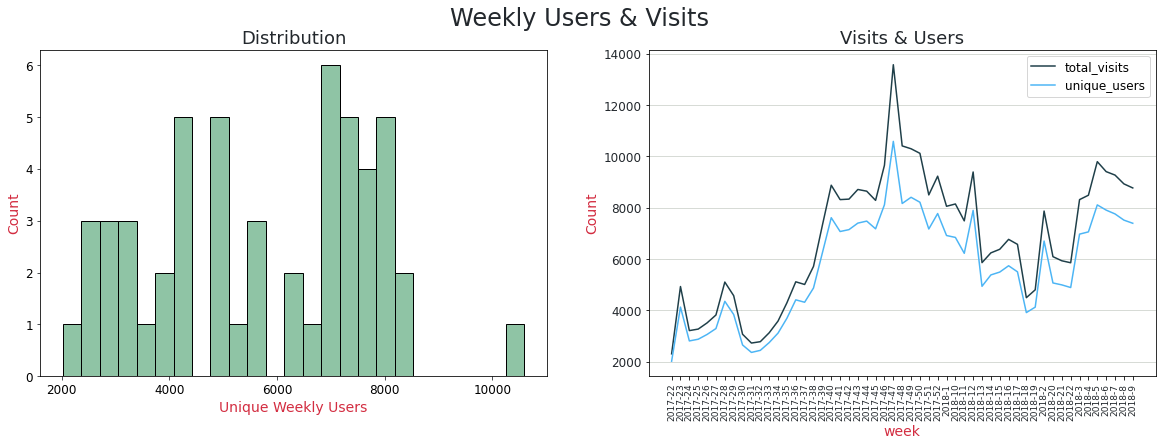

In [24]:
visits_plots(weekly_visits, 'Weekly', 'week', 9)

**Conclusion**

The number of users that visit our website during one week differs greatly. In summer 2017 we had the smallest numbers of users (**around 3.000**) after it seemed to be picking up at first. From calendar week 32 and on the weekly users increased steadily, reaching more than **10.000** users and almots **14.000** visits in calendar week 47. After that the number dropped to the levels from the weeks before and seems to be decreasing ever since. In calendar week 18 for example we only had visits from around **4.000** users.

Looking at the histogram we can see that most weeks have between **6.400** and **8.100** users, but there are also several weeks with less than **4.000** users. 

Consindering that we are only looking at data from a one year period, we could assume that this fluctuation is due to seasonality factors. People might be looking more for events and gift vouchers in the winter time, especially around christmas, while in summer there are not as many concerts or people are on vacation.

As we saw before while looking at the daily visits, the metrics confirm that on average more people per week use their desktop devices to access our website (4208) than their touch devices (1666). On average **5716** users visit our website per week.

[back to content](#top) | [back to Reports and Metrics](#2)

<a id="2.1.4"></a>
#### Monthly Users & Visits

In [25]:
# calculating the number of visits and number of unique users for each week
monthly_users = (visits
                .groupby('month')
                .agg({'uid':['count','nunique']})
                .reset_index()
                .sort_values('month'))

# renaming the columns
monthly_users.columns = ['month', 'total_visits', 'unique_users']

# taking a look at the data
display(monthly_users.head(10))

# displaying information about the values in both columns
display(monthly_users.describe())

# calculating the DAU, separated for devices
MAU = monthly_users['unique_users'].mean()
MAU_touch = (visits[visits['device'] == 'touch']
             .groupby('month')
             .agg({'uid':'nunique'})
             .reset_index()
             .uid
             .mean())

# calculating the MAU, separated for devices
MAU_desktop = (visits[visits['device'] == 'desktop']
               .groupby('month')
               .agg({'uid':'nunique'})
               .reset_index()
               .uid
               .mean())

# printing the metrics
print('MAU:', round(MAU))
print('MAU Touch:', round(MAU_touch))
print('MAU Desktop:', round(MAU_desktop))

,month,total_visits,unique_users
0,2017-06-01,16505,13259
1,2017-07-01,17828,14183
2,2017-08-01,14355,11631
3,2017-09-01,23907,18975
4,2017-10-01,37903,29692
5,2017-11-01,43969,32797
6,2017-12-01,41983,31557
7,2018-01-01,36939,28716
8,2018-02-01,37182,28749
9,2018-03-01,35679,27473


,total_visits,unique_users
count,12.000000,12.000000
mean,29950.000000,23228.416667
std,10307.835846,7546.380462
min,14355.000000,11631.000000
25%,22387.250000,17777.000000
50%,31157.000000,24240.500000
75%,37362.250000,28984.750000
max,43969.000000,32797.000000


MAU: 23228
MAU Touch: 6826
MAU Desktop: 16725


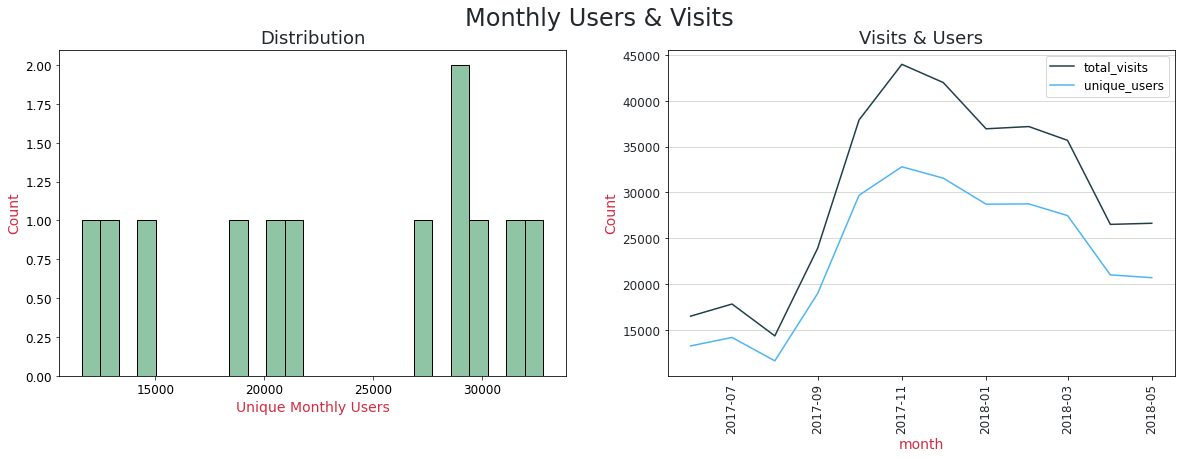

In [26]:
visits_plots(monthly_users, 'Monthly', 'month', 12)

**Conclusion**

The picture we get from looking at the monthly number of visits and unique users is similar to the weekly one. The period we're looking at started slowly and reached an alltime low in August 2017 with less than 
**15.000** visits from less than **12.000** unique users. From there on the number of monthly users increased quickly and reached it's highest point in November with almost **33.000** users that visited the website **44.000** times. In April and May 2018 the number dropped again to only around **21.000** users.

[back to content](#top) | [back to Reports and Metrics](#2)

<a id="2.1.5"></a>
#### Sticky WAU and MAU

In addition to the number of daily, weekly and monthly users let's find the *Sticky Factor*, or customer loyalty. We will calculate how many unique users return to the website on weekly or monthly basis.

In [27]:
# calculating and printing the sticky factor for weekly returns
print('Sticky WAU: {:.2f}'.format((DAU/WAU)*100))
print('Sticky WAU touch: {:.2f}'.format((DAU_touch/WAU_touch)*100))
print('Sticky WAU Desktop: {:.2f}'.format((DAU_desktop/WAU_desktop)*100))

Sticky WAU: 15.88
Sticky WAU touch: 15.47
Sticky WAU Desktop: 15.96


In [28]:
# calculating and printing the sticky factor for monthly returns
print('Sticky MAU: {:.2f}'.format((WAU/MAU)*100))
print('Sticky MAU touch: {:.2f}'.format((WAU_touch/MAU_touch)*100))
print('Sticky MAU Desktop: {:.2f}'.format((WAU_desktop/MAU_desktop)*100))

Sticky MAU: 24.61
Sticky MAU touch: 23.95
Sticky MAU Desktop: 24.69


**Conclusion**

The **Sticky Factor** doesn't differ much between the devices *touch* and *desktop*. around 15% of users return on a weekly basis while almost 25% of users visit the website again in the span of a month.

This also means that 75% of users didn't come back to user our services again within a month.

[back to content](#top) | [back to Reports and Metrics](#2)

<a id="2.1.6"></a>
#### Session Lenght

We want to find out how much time users usually spend on our site. To do this we will only consider session that had a lenght of more than 0 seconds, since we think that those sessions were abandoned before the site was actually loaded. We will also break down the average session lenght for different devices and compare the change over the weeks.

Number of Visits with Duration: 323606
Average Duration: 715
Average Duration Desktop: 774
Average Duration Touch: 548


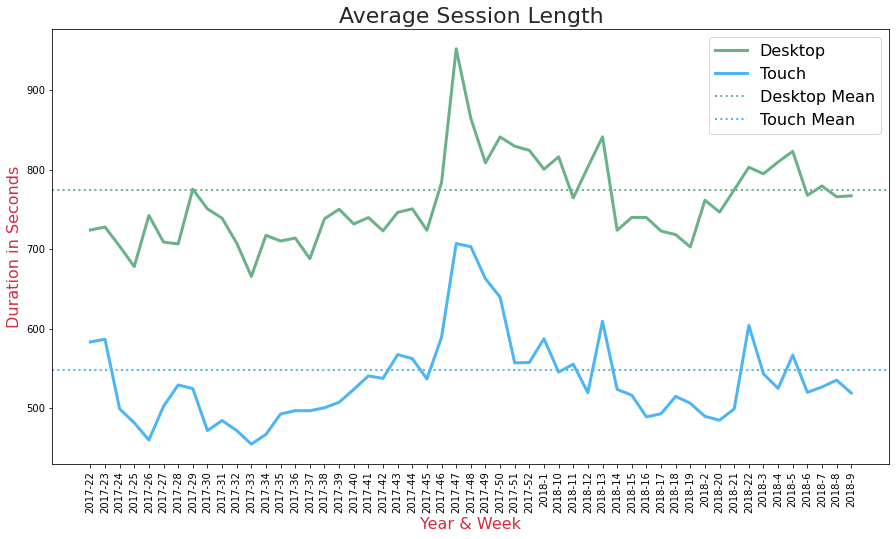

In [29]:
# filtering for visits with duration
visits_with_duration = visits[visits['duration'] > 0]

# calculating the mean durations for general and different devices
asl_mean = visits_with_duration['duration'].mean()
asl_desktop_mean = visits_with_duration[visits_with_duration['device'] == 'desktop']['duration'].mean()
asl_touch_mean = visits_with_duration[visits_with_duration['device'] == 'touch']['duration'].mean()

# printing the metrics
print('Number of Visits with Duration:', len(visits_with_duration))
print('Average Duration:', round(asl_mean))
print('Average Duration Desktop:', round(asl_desktop_mean))
print('Average Duration Touch:', round(asl_touch_mean))

# calculating the mean visit duration for each week and device
weekly_duration = (visits_with_duration
                   .groupby(['device', 'week'])
                   .agg({'duration':'mean'})
                   .reset_index())

# setting up the plot
plt.figure(figsize=(15,8))
plt.title('Average Session Length', fontsize=22, color=header)
plt.xlabel('Year & Week', fontsize=16, color=accent1)
plt.ylabel('Duration in Seconds', fontsize=16, color=accent1)
plt.xticks(rotation=90)

# plotting average duration for desktop users
plt.plot(weekly_duration[weekly_duration['device'] == 'desktop']['week'],
         weekly_duration[weekly_duration['device'] == 'desktop']['duration'],
         linewidth=3,
         color=data1,
         label='Desktop')

# plotting average duration for touch users
plt.plot(weekly_duration[weekly_duration['device'] == 'touch']['week'],
         weekly_duration[weekly_duration['device'] == 'touch']['duration'],
         linewidth=3,
         color=data3,
         label='Touch')


# adding lines for the mean visit duration
plt.axhline(asl_desktop_mean,
            linestyle='dotted',
            linewidth=2,
            color=data1,
            label='Desktop Mean')

plt.axhline(asl_touch_mean,
            linestyle='dotted',
            linewidth=2,
            color=data3,
            label='Touch Mean')

plt.legend(fontsize=16)

# displaying the graph
plt.show()

**Conclusion**

We split the data by the kind of device that users used to access our website (*Desktop* and *Touch*). In general visits from a desktop device last longer (**774 seconds**) than a visit from a touch device (**548 seconds**).

Even though the average lenght differs over time the curves for both devices stay similiar, if visits get longer for desktop devices they tend to get longer for touch devices. But there are a few weeks where this is different. For example in week 26 the average duration from desktop devices increased while the duration from touch devices decreased. This could be due to a new feature we introduced on the website and was only for the desktop version or made navigating the website harder. It could also be the other way around and touch users abandonded the site early.

[back to content](#top) | [back to Reports and Metrics](#2)

<a id="2.1.7"></a>
#### User Retention

Now let's find out how often users come back. We already found the number of DAU, WAU and MAU. To find out more about our users we will check how often users from certain groupes visit our website each month on average.

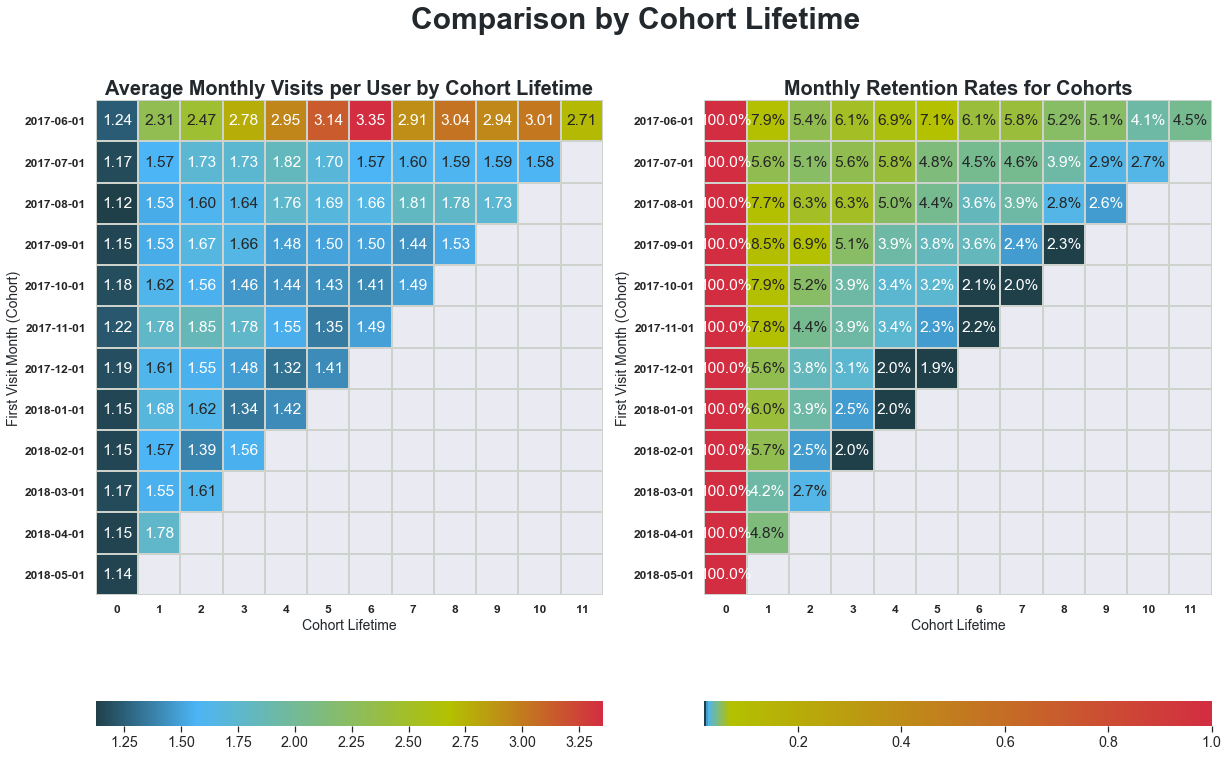

In [30]:
# grouping users by month of first visit
visits_grouped_by_cohorts = (visits.groupby(['first_visit', 'month'])
                                   .agg({'uid':['nunique','count'], 'cohort_lifetime':'mean'})
                                   .reset_index())

# renaming the columns
visits_grouped_by_cohorts.columns = ['first_visit', 'month', 'unique_users', 'total_visits', 'cohort_lifetime']
visits_grouped_by_cohorts['first_visit'] = visits_grouped_by_cohorts['first_visit'].astype(str)

# calculating average number of visits per user for each cohort and month
visits_grouped_by_cohorts['visits_per_user'] = visits_grouped_by_cohorts['total_visits']\
                                                / visits_grouped_by_cohorts['unique_users']

# creating a table with average visits per user in each cohort and lifetime month
lifetime_pivot = visits_grouped_by_cohorts.pivot_table(index='first_visit',
                                                       columns='cohort_lifetime',
                                                       values='visits_per_user',
                                                       aggfunc='sum')

# calculating initial number of unique users for each cohort
initial_users_count = visits_grouped_by_cohorts[visits_grouped_by_cohorts['cohort_lifetime'] == 0]\
                        [['first_visit', 'unique_users']]

# renaming the columns
initial_users_count = initial_users_count.rename(columns={'unique_users':'cohort_users'})

# merging the tables with number of unique users and initial user count
visits_grouped_by_cohorts = visits_grouped_by_cohorts.merge(initial_users_count,
                                                            on='first_visit', how='left')

# storing retention rates for each cohort and month in a new column
visits_grouped_by_cohorts['retention'] = visits_grouped_by_cohorts['unique_users']\
                                         / visits_grouped_by_cohorts['cohort_users']

# creating a table with retention rates in each cohort and lifetime month
retention_pivot = visits_grouped_by_cohorts.pivot_table(index='first_visit',
                                                        columns='cohort_lifetime',
                                                        values='retention')

# setting up a plot for heatmaps
plt.figure(figsize=(20,13))
plt.tight_layout()
plt.suptitle('Comparison by Cohort Lifetime',
             fontsize=30,
             fontweight='bold',
             color=header)

sns.set(font_scale=1.3)

# creating a heatmap on average visits per user
plt.subplot(1,2,1)

plt.title('Average Monthly Visits per User by Cohort Lifetime',
          fontsize=20,
          fontweight='bold',
          color=header)

heatmap = sns.heatmap(lifetime_pivot,
                      annot=True,
                      fmt='.2f',
                      linewidths=1,
                      linecolor=neutral,
                      cmap=cmap,
                      cbar_kws={'orientation': 'horizontal'})

plt.ylabel('First Visit Month (Cohort)',fontsize=14, color=header)
plt.xlabel('Cohort Lifetime', fontsize=14, color=header)

heatmap.set_yticklabels(heatmap.get_yticklabels(),
                        rotation=0,
                        fontsize=12,
                        fontweight='bold')

heatmap.set_xticklabels(heatmap.get_xticklabels(),
                        fontsize=12,
                        fontweight='bold')

# creating a heatmap on retention rates with different color thresholds
colors_retention = [[norm(-1.), data2],
          [norm(-0.99), data3],
          [norm(-0.9), accent2],
          [norm( 1.0), accent1]]

cmap_retention = matplotlib.colors.LinearSegmentedColormap.from_list("", colors_retention)

plt.subplot(1,2,2)
plt.title('Monthly Retention Rates for Cohorts',
          fontsize=20,
          fontweight='bold',
          color=header)

heatmap = sns.heatmap(retention_pivot,
                      annot=True,
                      fmt='.1%',
                      linewidths=1,
                      linecolor=neutral,
                      cmap=cmap_retention,
                      cbar_kws={'orientation': 'horizontal'})

plt.ylabel('First Visit Month (Cohort)', fontsize=14, color=header)
plt.xlabel('Cohort Lifetime', fontsize=14, color=header)

heatmap.set_yticklabels(heatmap.get_yticklabels(),
                        rotation=0,
                        fontsize=12,
                        fontweight='bold')

heatmap.set_xticklabels(heatmap.get_xticklabels(),
                        fontsize=12,
                        fontweight='bold')

# showing the plot
plt.show()

**Conclusion**

What first springs to attention is that users from the first cohort that started using our services in June 2017 are the ones that visit our website most frequently. Even though they started with **1.24** visits per month, which is only slightly higher than in other cohorts, after that each user from that cohort visits the site around **3** times per month. 

The other cohorts have similar numbers of visits per user for each lifetime month, usually between **1.3** and **1.6** visits per month. It's interesting to see that users from younger cohorts seem to use our services less often than those who have been using it for a longer time.

Looking at the retention, meaning the number of unique users from each cohort that come back at least once a month to use our services we can see a similar pattern. Many users from the first cohort still come back frequently. Even after one year there are still **4.5%** of the users that visited our site for the first time in June 2017 come back to the website. In their 5th lifetime month it still was **7.1%**. Comparing other cohorts the numbers decline much quicker. For example the second cohort (first visit in July 2017) only had **4.8%** of users returning in the 5th month. With each cohort the number of users that come back gets shorter. Maybe our website isn't as attractive to new users that don't know how to navigate the site or there are competitors that attract the same users as we do, so only people who already are familiar with our service stay loyal.

[back to content](#top) | [back to Reports and Metrics](#2)

<a id="2.2"></a>
### Sales

* [When do People start buying?](#2.2.1)
* [Number of Orders](#2.2.2)
* [Average Purchase Size](#2.2.3)
* [Lifetime Value](#2.2.4)

<a id="2.2.1"></a>
#### When do People start Buying?

,uid
source_id,
1,34121
2,47626
3,85610
4,101794
5,66905
6,6
7,36
9,13277
10,10025


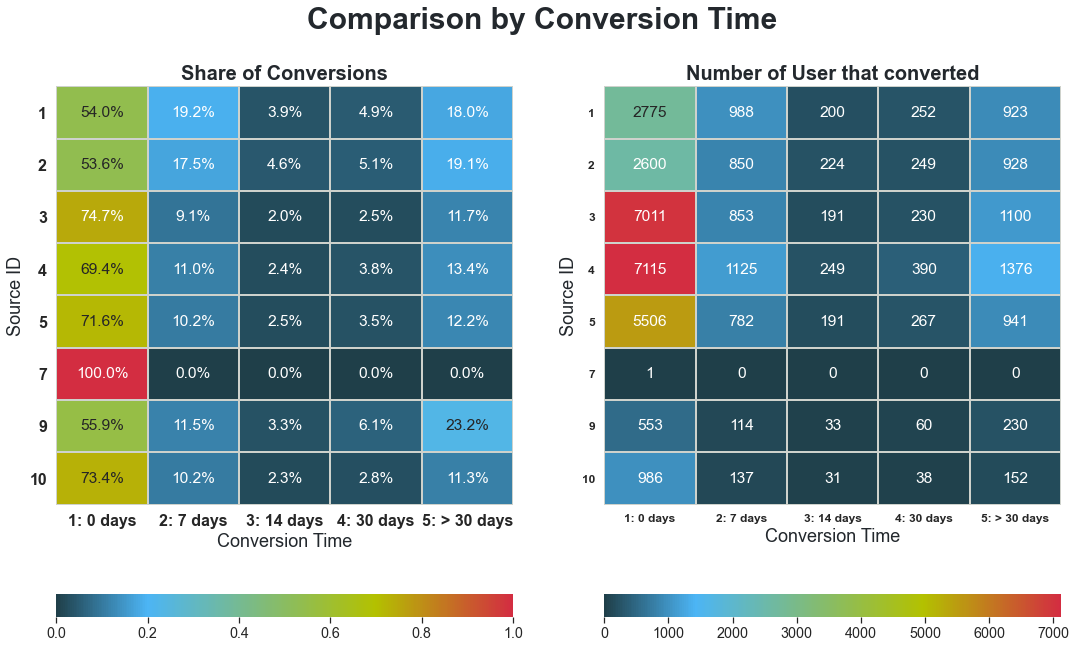

In [31]:
# finding the date of first order for each user and source
first_orders = orders.groupby('uid')['date'].min().reset_index()

# joining it with the first visits for each user
user_conversion = first_orders.reset_index().merge(first_visit, on='uid', how='left')

# renaming the columns
user_conversion = user_conversion.rename(columns={'date':'first_order'})

# calculating after how many days the first order was placed
user_conversion['conversion_days'] = ((user_conversion['first_order']\
                                         - user_conversion['first_visit'])\
                                        / np.timedelta64(1, 'D')).astype(int)

# adding the information to the visits table
orders = orders.merge(user_conversion[['uid', 'conversion_days']], on='uid', how='left')

# defining a dunction that will add cohort name by conversion period
def cohort(row):
    conversion_days=row['conversion_days']
    
    if conversion_days == 0:
        cohort = '1: 0 days'
    elif  conversion_days <= 7:
        cohort = '2: 7 days'
    elif conversion_days <= 14:
        cohort = '3: 14 days'
    elif conversion_days <= 30:
        cohort = '4: 30 days'
    else:
        cohort = '5: > 30 days'
    return cohort

# applying the function to the visits table
orders['conversion_cohort'] = orders.apply(cohort,axis=1)

# adding the source_id to the orders table
sources = visits.pivot_table(index=['uid', 'date'], values='source_id', aggfunc='first').reset_index()
orders = orders.merge(sources, on=['uid', 'date'], how='left')

# filling missing missing source_ids with the previous or next one for the user
orders['source_id'] = orders.groupby('uid')['source_id'].ffill().bfill()

# filling in by hand (visits before midnight, orders on the next day but no reference to fill
orders.loc[orders['uid'] == 83872787173869366, 'source_id'] = 4
orders.loc[orders['uid'] == 3993697860786194247, 'source_id'] = 3
orders['source_id'] = orders['source_id'].astype(int)

# grouping users by sources and conversion_cohort
cohorts_by_source = orders.groupby(['source_id','conversion_cohort'])\
                          .agg({'uid':'nunique'})\
                          .reset_index()

# calculating the total number of users per source
conv_cohort_size = orders.groupby(['source_id']).agg({'uid':'nunique'})
cohorts_by_source = cohorts_by_source.merge(conv_cohort_size, on='source_id', how='left')
cohorts_by_source.columns = ['source_id', 'conversion_cohort', 'cohort_users', 'source_users']

# calculating the share 
cohorts_by_source['share'] = cohorts_by_source['cohort_users'] / cohorts_by_source['source_users']

# calculating the share of visits by source and conversion period
source_sales_pivot = cohorts_by_source.pivot_table(index='source_id',
                                             columns='conversion_cohort',
                                             values='share',
                                             aggfunc='mean').sort_values('source_id')

source_sales_pivot.replace(np.inf, np.nan)
source_sales_pivot.fillna(0, inplace=True)


# calculating the number of users by source and conversion period
source_users_pivot = cohorts_by_source.pivot_table(index='source_id',
                                             columns='conversion_cohort',
                                             values='cohort_users').sort_values('source_id')
source_users_pivot.fillna(0, inplace=True)
source_users_pivot = source_users_pivot.astype('int')

# checking how many visits there per for each source
display(visits.pivot_table(index='source_id', values='uid', aggfunc='count'))

# setting up a plot for heatmaps
plt.figure(figsize=(18, 11))
plt.tight_layout()
plt.suptitle('Comparison by Conversion Time', fontsize=30, fontweight='bold', color=header)
sns.set(font_scale=1.3)

# creating a heatmap on average visits per user
plt.subplot(1,2,1)
plt.title('Share of Conversions', fontsize=20, fontweight='bold', color=header)
heatmap = sns.heatmap(source_sales_pivot,
                      annot=True,
                      fmt='.1%',
                      linewidths=1,
                      linecolor=neutral,
                      cmap=cmap,
                      cbar_kws={'orientation': 'horizontal'})

plt.ylabel('Source ID', fontsize=18, color=header)
plt.xlabel('Conversion Time', fontsize=18, color=header)
heatmap.set_yticklabels(heatmap.get_yticklabels(),
                        rotation=0,
                        fontsize=16,
                        fontweight='bold')

heatmap.set_xticklabels(heatmap.get_xticklabels(),
                        fontsize=16,
                        fontweight='bold')

# creating a heatmap on retention rates
plt.subplot(1,2,2)
plt.title('Number of User that converted',
          fontsize=20,
          fontweight='bold',
          color=header)

heatmap = sns.heatmap(source_users_pivot,
                      annot=True,
                      fmt='g',
                      linewidths=1,
                      linecolor=neutral,
                      cmap=cmap,
                      cbar_kws={'orientation': 'horizontal'})

plt.ylabel('Source ID', fontsize=18, color=header)
plt.xlabel('Conversion Time', fontsize=18, color=header)
heatmap.set_yticklabels(heatmap.get_yticklabels(),
                        rotation=0, fontsize=12,
                        fontweight='bold')
heatmap.set_xticklabels(heatmap.get_xticklabels(),
                        fontsize=12,
                        fontweight='bold')

# showing the plot
plt.show()

**Conclusion**

First of all we can see that we had zero conversions from sources **\#6 or \#8**. But seeing that we had very few visits from these sources this isn't very surprising.

In general most users seem to first place an order on their first visit. For most sources more than **50%** of people buy on their first visit. Especially successfully sources seem to be **\#3** and **\#10** with 74.7% and 73.4%. Closely followed by **\#4** and **\#5** with 69.4% and 71.6%. The source with the least conversions on the first day is **\#2** with only 53.6%. For most sources around 10% of users convert within the first 7 days after the first visit but after that the number declines. If a person didn't convert within the first week they most likely won't convert within the first month but at a later point (if at all).

For most sources there is quite a high number of users that convert at some point after 30 days. Especially for source **\#9** a lot of users only converted after more than a month. Maybe these users visited the website first from a different source and then later chose this source to visit the website again.

The sources with the highest number of users that converted are **\#3** and **\#4** with more than 7.000 users that placed an order on their first visit, followed by **\#5** with around 5.500 orders on the first visit. Sources **\#9** and **\#10** have the lowest number of users that converted (on the first day) with only 553 and 986 each.

Source **\#7** is an outlier with only one order at all.

<a id="2.2.2"></a>
#### Number of Orders

Let's go back to our cohorts (by first visit month) and see how many orders they place on average per day.

In [32]:
orders['first_visit'] = orders['first_visit'].astype('datetime64[M]')
orders_by_cohort = orders.pivot_table(index='first_visit', values='uid', aggfunc={'count','nunique'}).reset_index()
orders_by_cohort['orders_per_user'] = orders_by_cohort['count'] / orders_by_cohort['nunique']

display(orders_by_cohort)

,first_visit,count,nunique,orders_per_user
0,2017-06-01,6397,2923,2.188505
1,2017-07-01,3545,2458,1.442229
2,2017-08-01,2638,1721,1.532830
3,2017-09-01,4346,3058,1.421190
4,2017-10-01,6233,4678,1.332407
5,2017-11-01,5983,4262,1.403801
6,2017-12-01,5236,4074,1.285223
7,2018-01-01,3864,3119,1.238859
8,2018-02-01,3866,3186,1.213434
9,2018-03-01,3545,2838,1.249119


**Conclusion**

Again, our loyal users from the first cohort (first visit in June 2017) place the most orders. On average each active (and paying) user that bought at least once places **6.34** orders per month. For almost all other cohorts the number of orders per converted user is between **1.2** and **1.5**. Considering that we already found out that people who don't convert in the first days will probably only convert after a few month we can assume that the numbers for our users from the youngest cohorts will go up in the future.

<a id="2.2.3"></a>
#### Average Purchase Size

We already know when and from what source most users convert. Now let's find out how high the revenue is on average for each source and month.

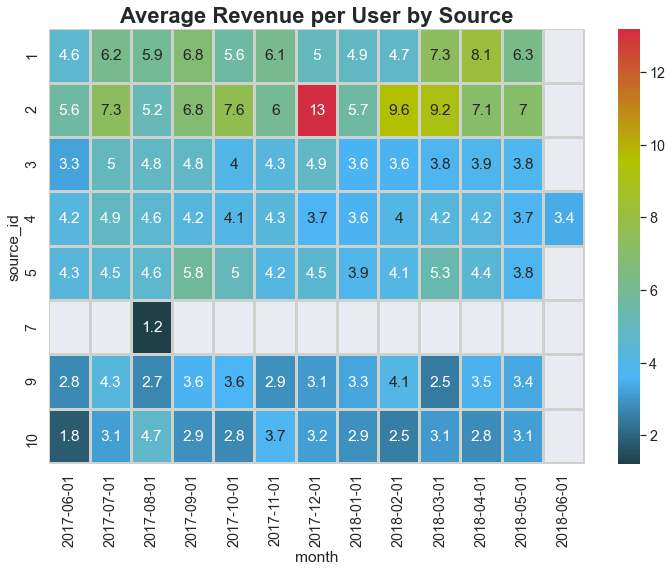

,source_id,revenue
0,1,5.926819
1,2,8.064857
2,3,4.094400
3,4,4.056097
4,5,4.559039
5,7,1.220000
6,9,3.163051
7,10,2.951852


In [33]:
# calculating average revenue by source and month
orders['month'] = orders['month'].astype(str)
cohort_orders = orders.pivot_table(index='source_id', columns='month', values='revenue', aggfunc='mean')

#plotting a heatmap
plt.figure(figsize=(12,8))
plt.title('Average Revenue per User by Source', fontsize=22, fontweight='bold', color=header)
sns.heatmap(cohort_orders, cmap=cmap, annot=True, linewidth=2, linecolor=neutral)
plt.show()

# average revenue per source
display(orders.groupby('source_id')['revenue'].agg('mean').reset_index())

**Conclusion**

Users that came from sources **\#1** and **\#2** seem to spend the highest amounts on average (~ USD 7.00). There were even several month were the average revenue per order was close to or USD 10.00, like September 2017 and April and May 2018.

In December 2017 buyers from source **\#2** spend USD 13.00 per order on average. We also had a lot of visits. Maybe we had a Christmas Promotion or people were buying gifts.

Other sources are not as profitable. Users that came from other sources usually don't spend more than USD 5.00 and there are only a few month were the average revenue from these sources was higher. Users from source **\#10** only spend USD 2.95 per order, sometimes even less.

<a id="2.2.4"></a>
#### LTV by Source

We want to find out how much revenue users (per source) make during their lifetime.

In [34]:
# finding the number of buyers from each source
n_buyers_source = orders.groupby('source_id').agg({'uid':'nunique'})
n_buyers_source = n_buyers_source.rename(columns={'uid':'n_buyers_source'})
orders = orders.merge(n_buyers_source, on='source_id', how='left')

# creating a report with revenue per source and month
ltv_source_report = orders.groupby(['source_id','month']).agg({'n_buyers_source':'mean','revenue': 'sum'}).reset_index()
ltv_source_report['ltv'] = ltv_source_report['revenue'] / ltv_source_report['n_buyers_source']

# finding the ltv for each source
ltv_source = ltv_source_report.groupby('source_id').agg({'n_buyers_source':'mean', 'revenue':'sum', 'ltv':'sum'})
ltv_source

,n_buyers_source,revenue,ltv
source_id,,,
1,5138,45298.68,8.816403
2,4851,61663.90,12.711585
3,9385,43146.79,4.597420
4,10255,48308.12,4.710689
5,7687,45248.46,5.886361
7,1,1.22,1.220000
9,990,3991.77,4.032091
10,1344,4398.26,3.272515


**Conclusion**

The users that came to us through source **\#2** have the highest spending habits. On average each paying user from this source spend USD 12.71. Users from other sources spend less than that, but **\#1** and **\#5** still have LTVs of USD 8.81 and USD 5.89. For all other sources the LTV is below USD 5.00.

<a id="2.2.5"></a>
#### LTV by Cohort

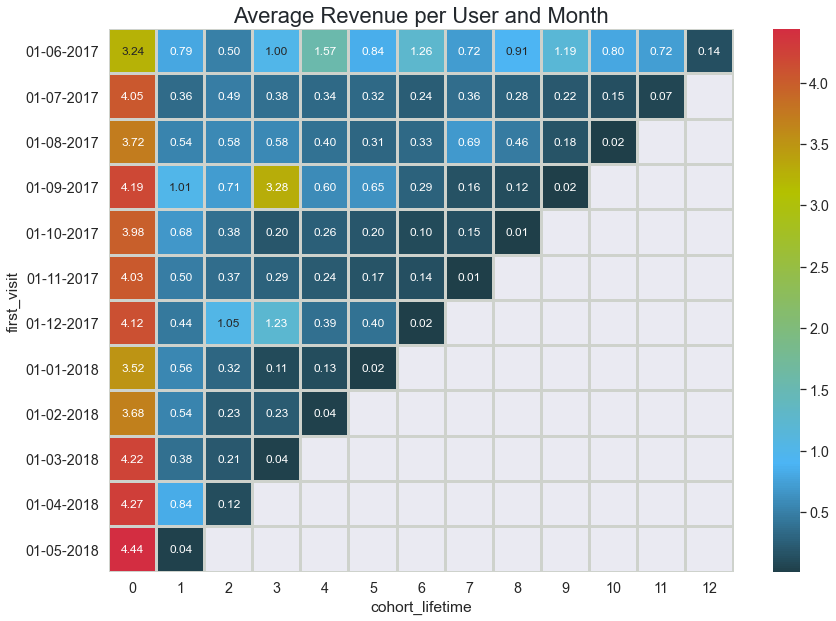

,first_visit,revenue,n_buyers_cohort,ltv
0,2017-06-01,40026.05,2923,13.693483
1,2017-07-01,17812.11,2458,7.246587
2,2017-08-01,13461.87,1721,7.822121
3,2017-09-01,33682.56,3058,11.014572
4,2017-10-01,27857.69,4678,5.955043
5,2017-11-01,24426.72,4262,5.731281
6,2017-12-01,31157.85,4074,7.647975
7,2018-01-01,14546.82,3119,4.663937
8,2018-02-01,15061.29,3186,4.727335
9,2018-03-01,13770.16,2838,4.852065


In [35]:
# finding the number of buyers for each cohort by first visit month
n_buyers_cohort = orders.groupby('first_visit').agg({'uid':'nunique'}).reset_index()
n_buyers_cohort = n_buyers_cohort.rename(columns={'uid':'n_buyers_cohort'})
orders = orders.merge(n_buyers_cohort, on='first_visit', how='left')

# making a report on the revenue by cohort and lifetime
ltv_report = (orders
              .groupby(['first_visit','cohort_lifetime'])
              .agg({'n_buyers_cohort':'mean','revenue': 'sum'})
              .reset_index())

# calculating the revenue per month and user
ltv_report['ltv'] = ltv_report['revenue'] / ltv_report['n_buyers_cohort']

# finding the average ltv for each cohort
ltv_by_cohort = orders.groupby('first_visit').agg({'revenue':'sum', 'n_buyers_cohort':'mean'}).reset_index()
ltv_by_cohort['ltv'] = ltv_by_cohort['revenue']/ltv_by_cohort['n_buyers_cohort']

# creating a pivot table and plotting a heatmap
output = ltv_report.pivot_table(index='first_visit', columns='cohort_lifetime', values='ltv', aggfunc='sum')
plt.figure(figsize=(14,10))
plt.title('Average Revenue per User and Month', fontsize=22, color=header)
heatmap = sns.heatmap(output, cmap=cmap, annot=True, annot_kws={"size": 12}, linewidth=2, linecolor=neutral, fmt='.2f')
heatmap.set_yticklabels(output.index.strftime('%d-%m-%Y'))
plt.show()

display(ltv_by_cohort)

**Conclusion**

Most cohorts make the gross of their total revenue in the first order month. Only the cohort from September 2017 had one month where the average revenue per user was above USD 3.00, usually it is less than USD 1.00.

For LTV it is most interesting to look at the older cohorts. The buyers that first visited our site in June 2017 have an average total revenue of USD 13.69, the buyers from September have an average total revenue of USD 11.01. The two cohorts between them each have an average revenue per user of around USD 7.50. Considering that the monthly revenue is very low for later lifetime month it probably won't get any higher. On average we shouldn't expect a lifetime value of more than approximately USD 10.00.

<a id="2.3"></a>
### Marketing

<a id="2.3.1"></a>
####  Total Costs Overall/per source/over time

In [36]:
# calculating total costs
total_costs = costs['costs'].sum()

# calculating costs per source
costs_by_source = costs.groupby('source_id').agg({'costs':'sum'}).reset_index()

# calculating costs per month
costs_per_month = costs.groupby('month').agg({'costs':'sum'}).reset_index()

# calculating costs per source and month
monthly_costs_source = costs.groupby(['source_id', 'month']).agg({'costs':'sum'}).reset_index()
monthly_costs_source = monthly_costs_source.pivot_table(index='source_id', columns='month')

print('Total Costs:', total_costs)
print()
print('Total Costs per Source:')
display(costs_by_source)
print('Total Costs per Month:')
display(costs_per_month)
display(monthly_costs_source)

Total Costs: 329131.62

Total Costs per Source:


,source_id,costs
0,1,20833.27
1,2,42806.04
2,3,141321.63
3,4,61073.60
4,5,51757.10
5,9,5517.49
6,10,5822.49


Total Costs per Month:


,month,costs
0,2017-06-01,18015.00
1,2017-07-01,18240.59
2,2017-08-01,14790.54
3,2017-09-01,24368.91
4,2017-10-01,36322.88
5,2017-11-01,37907.88
6,2017-12-01,38315.35
7,2018-01-01,33518.52
8,2018-02-01,32723.03
9,2018-03-01,30415.27


costs                                                         \
month     2017-06-01 2017-07-01 2017-08-01 2017-09-01 2017-10-01 2017-11-01   
source_id                                                                     
1            1125.61    1072.88     951.81    1502.01    2315.75    2445.16   
2            2427.38    2333.11    1811.05    2985.66    4845.00    5247.68   
3            7731.65    7674.37    6143.54    9963.55   15737.24   17025.34   
4            3514.80    3529.73    3217.36    5192.26    6420.84    5388.82   
5            2616.12    2998.14    2185.28    3849.14    5767.40    6325.34   
9             285.22     302.54     248.93     415.62     609.41     683.18   
10            314.22     329.82     232.57     460.67     627.24     792.36   

                                                                             
month     2017-12-01 2018-01-01 2018-02-01 2018-03-01 2018-04-01 2018-05-01  
source_id                                                                    
1            2341.20    2186.18    2204.48    1893.09    1327.49    1467.61  
2            4897.80    4157.74    4474.34    3943.14    2993.70    2689.44  
3           16219.52   14808.78   14228.56   13080.85    9296.81    9411.42  
4            7680.47    5832.79    5711.96    5961.87    4408.49    4214.21  
5            5872.52    5371.52    5071.31    4529.62    3501.15    3669.56  
9             657.98     547.16     551.50     480.29     373.49     362.17  
10            645.86     614.35     480.88     526.41     388.25     409.86

**Conclusion**

We spent USD 329.131 on marketing during the year. In most month we spend more than USD 30.000, sometimes up to USD 38.000. Only in winter the marketing budget was significantly lower and only around USD 20.000.

The source that we invested most in was **\#3** with costs of USD 141.321 total. Other sources only cost us five digit numbers, for sources **\#9** and **\#10** we spent less than USD 6.000.

<a id="2.3.2"></a>
#### Customer Acquisiton Cost

We want to find out how much money we had to invest on average to attract a new paying customer. We will split this by source to find out which ones are profitable and which ones are expensive.

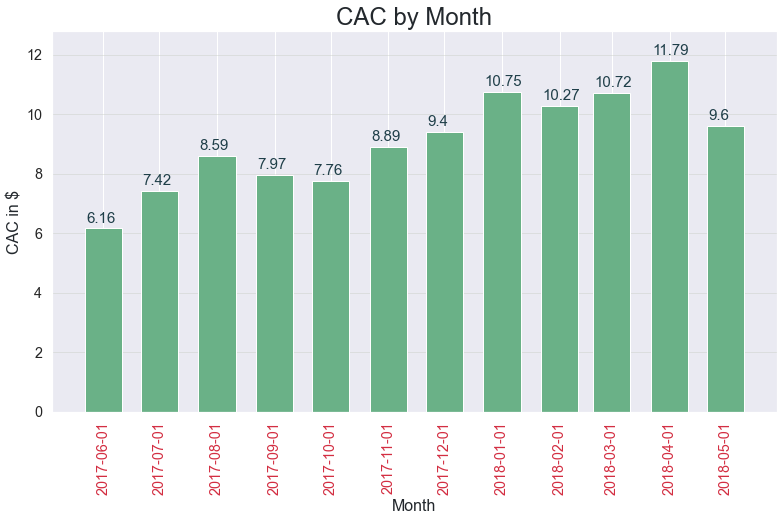

Mean CAC: 9.11124108656419


In [37]:
# calculating the customer accisition cost per month
CAC = costs_per_month.merge(ltv_by_cohort, left_on='month', right_on='first_visit', how='left')
CAC['cac'] = CAC['costs'] / CAC['n_buyers_cohort']

# defining the columns that we want to use in our graph
x=CAC['month']
y=CAC['cac']

# setting up the plot and some parameters
plt.figure(figsize = (13,7))
plt.title('CAC by Month', fontsize = 24, color=header)
plt.grid(color=neutral, axis='y', alpha=0.5)
plt.ylim(0,y.max()+1)

# the actual plot
bars = plt.bar(x, height=y, color=data1, width=20)

xlocs, xlabs = plt.xticks()


# adding some more information to the plot
plt.xlabel('Month', fontsize = 16, color = header)
plt.ylabel('CAC in $', fontsize = 16, color = header)
plt.xticks(CAC['month'].unique(), rotation=90, color=accent1)

# adding the amount of trips to each bar
for bar in bars:
    yval = round(bar.get_height(),2)
    plt.text(bar.get_x()+0.7, yval+0.2, yval, fontsize=15, color = data2)
    
# displaying the graph
plt.show()

print('Mean CAC:', CAC['cac'].mean())

**Conclusion**

Our customer acquisition cost seems to increase over time. In June 2017 we spend USD 6.16 on average to gain a new paying customer, but since January 2018 we usually spend more than USD 10 for each new buyer, in April 2018 it even was as high as USD 11.79. On average we spend USD 9.11 to get one new paying customer.

We already found out that only customers from a few cohorts spent this amount of money during their liftime so let's find out whether our investments were worthwile in the next step.

<a id="2.3.3"></a>
#### How worthwhile where the investments? (ROMI)

<a id="2.3.3.1"></a>
##### ROMI by Cohort

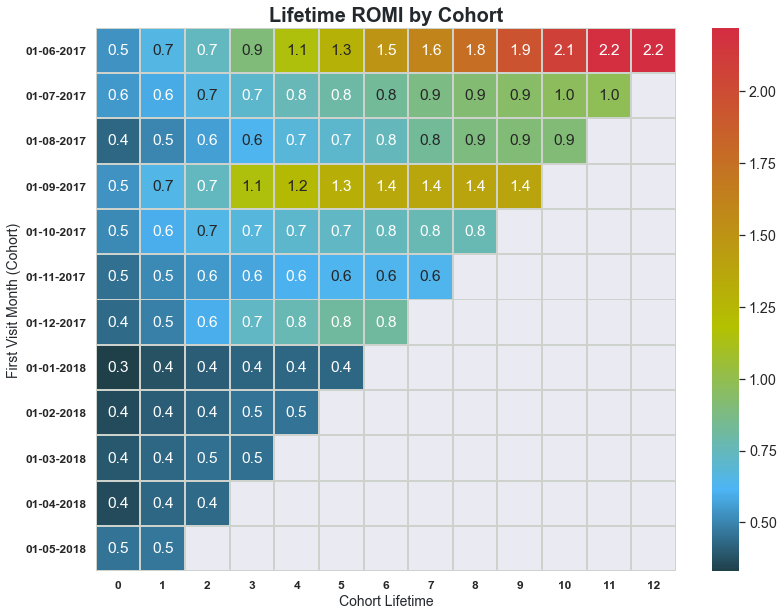

cohort_lifetime
0      0.445000
1      0.955000
2      1.523636
3      2.223000
4      3.034444
5      3.987500
6      5.160000
7      6.261667
8      7.736000
9      9.427500
10    10.193333
11    12.980000
12    18.580000
dtype: float64

In [38]:
# reducing CAC to CAC and first visit
CAC = CAC[['first_visit','cac']]

# adding CAC to the ltv_report
ltv_report = ltv_report.merge(CAC, on='first_visit', how='left')

# adding the costs for each month to the ltv_report
ltv_report = ltv_report.merge(costs_per_month, left_on='first_visit', right_on='month', how='left')

# calculating the ROMI
ltv_report['romi'] = ltv_report['ltv'] / ltv_report['cac']
ltv_report['first_visit'].astype(str)

# making a pivot table
output = ltv_report.pivot_table(
    index='first_visit', 
    columns='cohort_lifetime', 
    values='romi', 
    aggfunc='mean')

output = output.cumsum(axis=1).round(2)

# calculating the average breakeven month
romi_lifetime = output.cumsum(axis=1).mean(axis=0)

# creating a heatmapt for ROMI
colors_romi = [[norm(-1.0), data2],
          [norm(-0.7), data3],
          [norm(-0.1), accent2],
          [norm(1.0), accent1]]

cmap_romi = matplotlib.colors.LinearSegmentedColormap.from_list("", colors_romi)

plt.figure(figsize=(13,10))
plt.title('Lifetime ROMI by Cohort',
          fontsize=20,
          fontweight='bold',
          color=header)

heatmap = sns.heatmap(output,
                      annot=True,
                      fmt='.1f',
                      linewidths=1,
                      linecolor=neutral,
                      cmap=cmap_romi)

plt.ylabel('First Visit Month (Cohort)', fontsize=14, color=header)
plt.xlabel('Cohort Lifetime', fontsize=14, color=header)

heatmap.set_yticklabels(output.index.strftime('%d-%m-%Y'),
                        rotation=0,
                        fontsize=12,
                        fontweight='bold')

heatmap.set_xticklabels(heatmap.get_xticklabels(),
                        fontsize=12,
                        fontweight='bold')

# showing the plot
plt.show()

# displaying the average ROMI per lifetime month
display(romi_lifetime)

**Conclusion**

On average we reach the return of marketing investment after 10 months, which already is quite a long time. Only two cohorts (June 2017 and September 2017) reached the ROMI after a few months. The cohort of users that first visited our website in August 2017 are in their 10th month already and still haven't reached the ROMI. We need to find ways to make customers spend more money earlier.

<a id="2.3.3.2"></a>
##### ROMI by Source

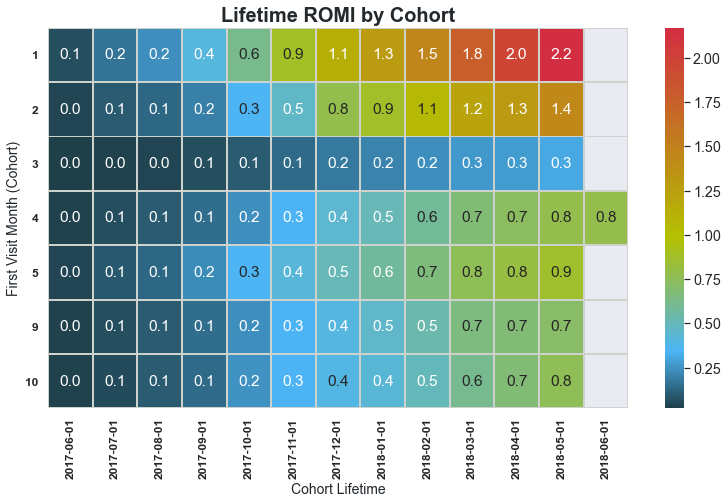

In [39]:
# making a report on the revenue by source and month
ltv_report_source = (orders
              .groupby(['source_id','month'])
              .agg({'n_buyers_source':'mean','revenue': 'sum'})
              .reset_index())

# calculating the revenue per month and user
ltv_report_source['ltv'] = ltv_report_source['revenue'] / ltv_report_source['n_buyers_source']
ltv_report_source = ltv_report_source.merge(costs_by_source, on='source_id', how='left')

# calculating the customer acquisition cost per source
ltv_report_source['cac'] = ltv_report_source['costs'] / ltv_report_source['n_buyers_source']

ltv_report_source['romi'] = ltv_report_source['ltv'] / ltv_report_source['cac']

# making a pivot table
output = ltv_report_source.pivot_table(
    index='source_id', 
    columns='month', 
    values='romi', 
    aggfunc='mean')

output = output.cumsum(axis=1).round(2)

# creating a heatmap
plt.figure(figsize=(13,7))
plt.title('Lifetime ROMI by Cohort',
          fontsize=20,
          fontweight='bold',
          color=header)

heatmap = sns.heatmap(output,
                      annot=True,
                      fmt='.1f',
                      linewidths=1,
                      linecolor=neutral,
                      cmap=cmap_romi)

plt.ylabel('First Visit Month (Cohort)', fontsize=14, color=header)
plt.xlabel('Cohort Lifetime', fontsize=14, color=header)

heatmap.set_yticklabels(output.index,
                        rotation=0,
                        fontsize=12,
                        fontweight='bold')

heatmap.set_xticklabels(heatmap.get_xticklabels(),
                        fontsize=12,
                        fontweight='bold')

# showing the plot
plt.show()

**Conclusion**

Only two source reached their Return of Marketing Investment yet. The most profitable source seems to be Source **\#1** where the ROMI was reached in December 2017 and by January we had a ROMI of 2.2, meaning that we made more than double in reveneue compared to the marketing costs we had for it. Source **\#2** also reached ROMI in February and continues to increase. 

Most other sources haven't reached ROMI yet but some are close. Except for Source **\#3** where even in May 2018 the ROMI was only 0.3, meaning that we only got 30% of our marketing investment back as revenue.

<a id="2.3.3.3"></a>
##### Profit by Source

In [40]:
# revenue_per source
profit_source = ltv_report_source.groupby('source_id').agg({'revenue':'sum', 'costs':'mean'})
profit_source['profit'] = profit_source['revenue'] - profit_source['costs']
profit_source

,revenue,costs,profit
source_id,,,
1,45298.68,20833.27,24465.41
2,61663.90,42806.04,18857.86
3,43146.79,141321.63,-98174.84
4,48308.12,61073.60,-12765.48
5,45248.46,51757.10,-6508.64
7,1.22,NaN,NaN
9,3991.77,5517.49,-1525.72
10,4398.26,5822.49,-1424.23


**Conclusion**

As we already found out only two sources made more revenue than they cost us in marketing costs. But some others are close. The biggest loss was created from source **\#3** with almost USD 100.000.

## General Conclusion

During our analysis we found out that these are the most profitable cohorts, sources and devices:

* Most of our users use a deskop device to vistit our website, the also spend more time on the website than touch device users
* The customers that already visited our website one year ago tend to visit the site more often and make more purchases
* Most users buy on their first visit or within the first week. After that they might return in later months for additional purchases
* The cost of acquiring new customers is around USD 9.00, but we spend more in the last month.
* The average amount of money a customer spends during their lifetime is USD 10.00
* Most cohorts only reach their ROMI after 10 months
* Customers spend more per order when they come from sources **\#1** or **\#2** but the number of buyers that order on their first visit come from sources **\#3, \#5** and **\#10**
* Only two sources reached their ROMI, some others are close, but some like **\#3** are far from reaching it.

We should concentrate our marketing efforts on sources that see early conversions, like **\#5 and \#10** and sources that see the highest and fastest revenue like **\#1, \#2** and **\#5**.

We spend USD 77.000 more than we made, we need to cut back the marketing budget by at least this amount.

We should cut back the budget on source **\#3** where a lot of users converted early and the number of buyers was the biggest, but they only spend USD 4.00 on average. We never came close to reaching ROMI from this source so maybe we should abandon this marketing channel altogether. Since we spend USD 141.321 on this source alone and only made USD 43.146 in return, abandoning this source would already gain us almost USD 100.000 which we could invest in more profitable sources.